In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

attention_map_path = "/home/stud/ghuang/Open-Sora/samples/samples/attention_maps/"
filenames = os.listdir(attention_map_path)

name = filenames[0]
attention_map = torch.load(os.path.join(attention_map_path, name), map_location=torch.device('cpu'))
!ls -l /home/stud/ghuang/Open-Sora/samples/samples/attention_maps/ | wc -l
attention_map.shape
# 216000 -> (2, 30, 45, 80), 30 is the number of frames


1681


torch.Size([1, 16, 216000, 42])

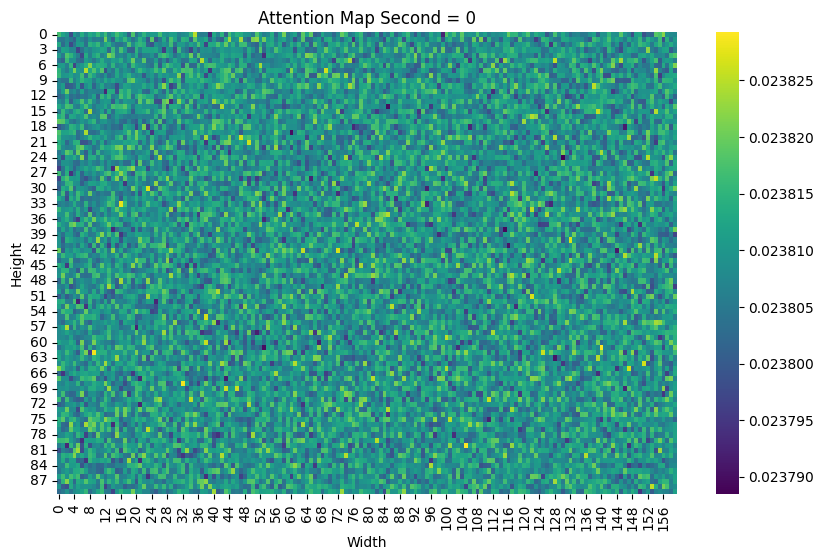

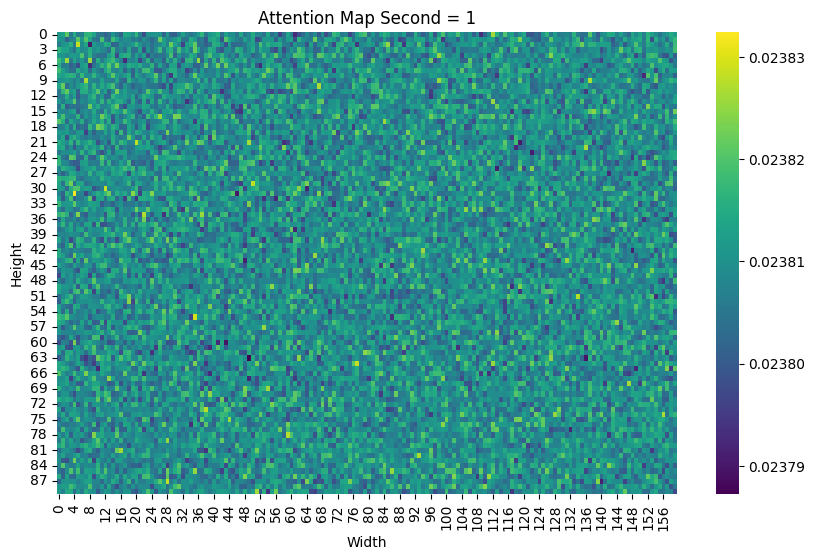

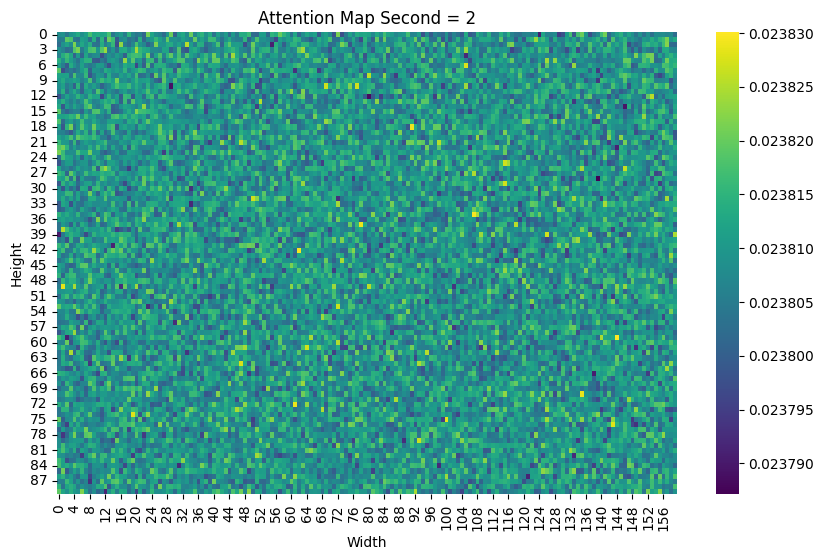

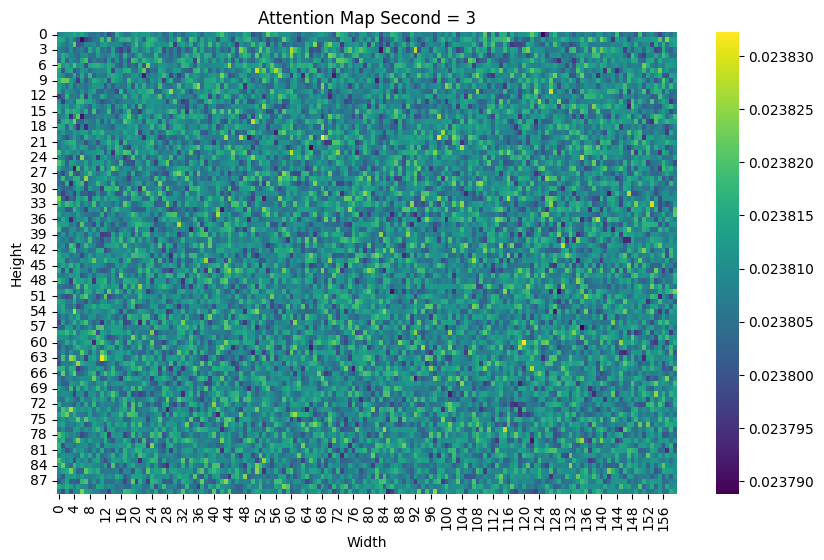

In [15]:
attention = attention_map
# Assuming attention is the output from `calculate_attention`
# attention: torch.Tensor of shape (1, 16, 57600, 42)
# Convert to numpy for easier processing
attention = attention.detach().cpu().float().numpy()

# Reduce over heads (16) and keys (42) for simplicity
attention_mean = attention.mean(axis=1)  # Average over heads (now 1, 57600, 42)
attention_spatial = attention_mean.mean(axis=-1).reshape(4, 90, 160)  # Average over keys, reshape to spatial

# Visualize one temporal slice (e.g., the first frame)
for i in range(4):
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_spatial[i], cmap="viridis")
    plt.title("Attention Map Second = " + str(i))
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

# Alternatively, visualize attention across prompt tokens for a single query location
# query_idx = 0  # Example: first spatial-temporal location
# attention_prompt = attention_mean[0, query_idx, :]
# plt.plot(attention_prompt)
# plt.title(f"Attention Across Prompt Tokens (Query {query_idx})")
# plt.xlabel("Prompt Token Index")
# plt.ylabel("Attention")
# plt.show()

1009
torch.Size([1, 16, 2, 30, 45, 80, 42])
torch.Size([30, 45, 80])


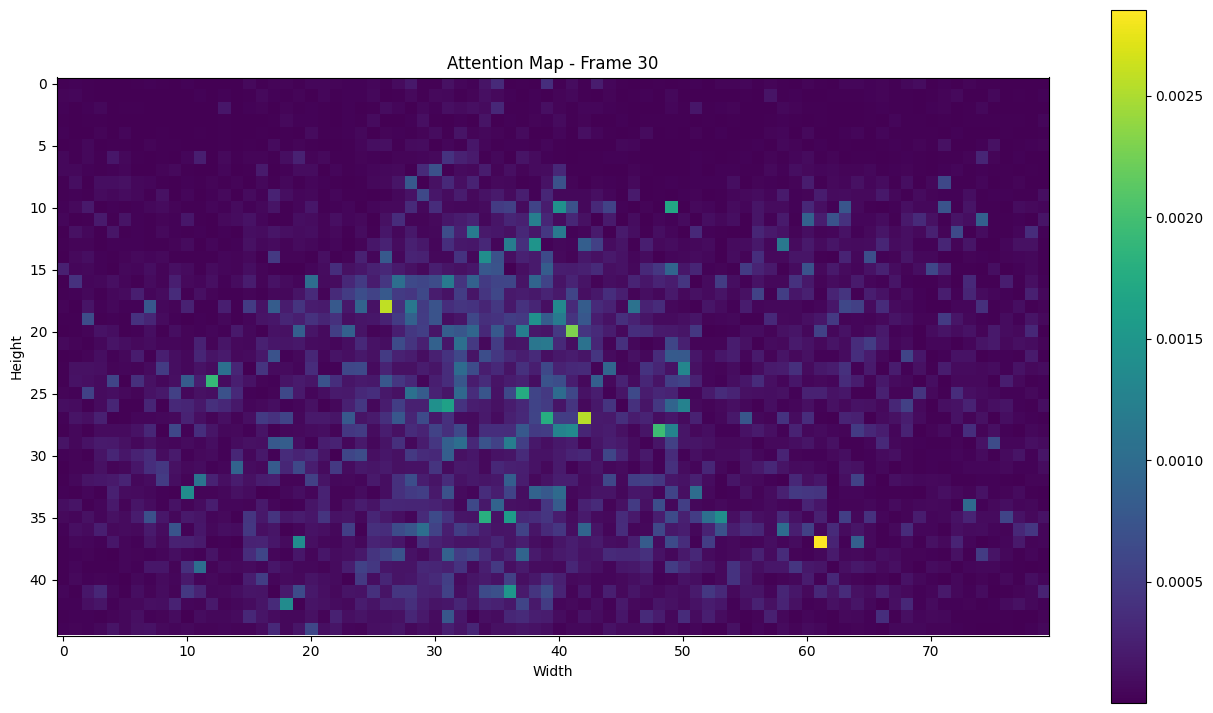

In [10]:
# this is used to visualize the attention map change across frames for one attention map tensor at one head for a specific token
from matplotlib.animation import FuncAnimation, PillowWriter
# Create a figure for the animation
def create_gif(frame_attention):
    num_frames, height, width = frame_attention.shape
    fig, ax = plt.subplots(figsize=(16, 9))
    cax = ax.imshow(frame_attention[0], cmap="viridis", interpolation="nearest")
    plt.colorbar(cax, ax=ax, orientation="vertical")
    ax.set_title("Attention Map - Frame 1")
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    
    # Function to update each frame
    def update(frame_idx):
        cax.set_array(frame_attention[frame_idx])  # Update heatmap data
        ax.set_title(f"Attention Map - Frame {frame_idx + 1}")
    
    # Create animation
    ani = FuncAnimation(fig, update, frames=num_frames, interval=1000)  # 500ms per frame
    
    # Save as a GIF
    ani.save("attention_animation.gif", writer=PillowWriter(fps=2))
    
    # Show the animation
    plt.show()

name = filenames[0]
attention_map = torch.load(os.path.join(attention_map_path, name), map_location=torch.device('cpu')).float().reshape(1, 16, 2, 30, 45, 80, 42)
!ls -l /home/stud/ghuang/Open-Sora/samples/samples/attention_maps/ | wc -l
print(attention_map.shape)

# attention_map = attention_map.mean(axis=1)  # Average over heads (now 1, 57600, 42)
attention_spatial = attention_map[0][0][0[..., 0]
print(attention_spatial.shape)
create_gif(attention_spatial)

In [ ]:
# this is used to create the attention map shift across the denoising process
from matplotlib.animation import FuncAnimation, PillowWriter
# Create a figure for the animation
def create_gif_denoising_process(tensor_list):
    num_frames, height, width = tensor_list[0].shape
    fig, ax = plt.subplots(figsize=(16, 9))
    cax = ax.imshow(tensor_list[0], cmap="viridis", interpolation="nearest")
    plt.colorbar(cax, ax=ax, orientation="vertical")
    ax.set_title("Attention Map - Step 1")
    ax.set_xlabel("Width")
    ax.set_ylabel("Height")
    
    # Function to update each frame
    def update(tensor_index):
        cax.set_array(tensor_list[tensor_index])  # Update heatmap data
        ax.set_title(f"Attention Map - Frame {tensor_index + 1}")
    
    # Create animation
    ani = FuncAnimation(fig, update, frames=len(tensor_list), interval=500)  # 500ms per frame
    
    # Save as a GIF
    ani.save("attention_animation_denoising_process.gif", writer=PillowWriter(fps=2))
    
    # Show the animation
    plt.show()

sorted_filenames = sorted(filenames) # make sure the filenames are read by the order of its generation
attention_map_list = []
for name in tqdm(sorted_filenames[0:2000:56]): # 28 depths, each level has one temporal block and one spatial block.
    attention_map = torch.load(os.path.join(attention_map_path, name), map_location=torch.device('cpu')).float().reshape(1, 16, 2, 30, 45, 80, 42)
    head_index = 0
    token_index = 0
    chosen_attention_map = attention_map[0][head_index][0][..., token_index]
    attention_map_list.append(chosen_attention_map)
create_gif_denoising_process(attention_map_list)

 53%|█████████████████████████████████████████████████████████▌                                                  | 16/30 [00:58<01:12,  5.17s/it]


00%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:22<00:00,  1.04s/it]

IndexError: index 8 is out of bounds for axis 0 with size 8

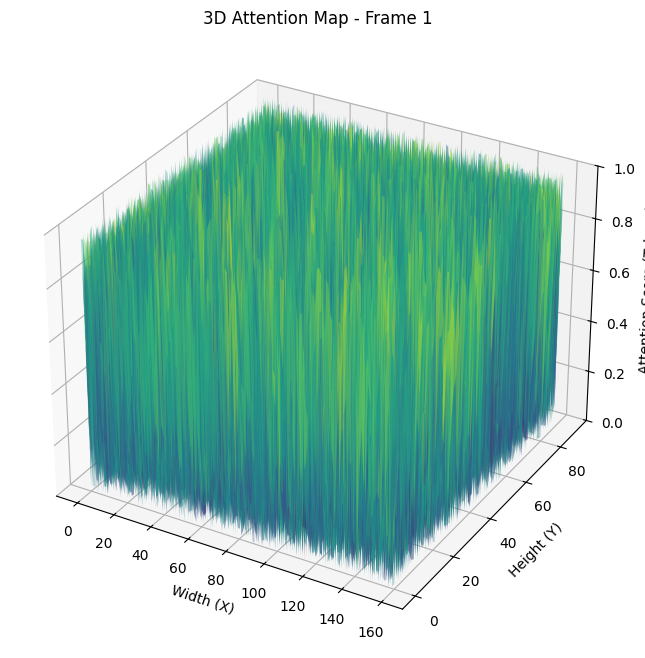

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

def create_3d_visualization_across_denoising(tensor_list):
    # Create a figure
    height, width, num_tokens = tensor_list[0].shape
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Prepare meshgrid for spatial dimensions
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    
    # Function to update the plot for each frame
    def update(tensor_index):
        ax.clear()  # Clear the previous frame
        ax.set_title(f"3D Attention Map - Frame {tensor_index + 1}")
        ax.set_xlabel("Width (X)")
        ax.set_ylabel("Height (Y)")
        ax.set_zlabel("Attention Score (Tokens)")
        ax.set_zlim(0, 1)  # Adjust Z-axis range if needed
    
        # Plot the attention map for each token as a surface
        for token in range(num_tokens):
            z = attention[tensor_index, :, :, token]  # Attention scores for this frame and token
            ax.plot_surface(x, y, z, cmap="viridis", alpha=0.3)
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(tensor_list), interval=500)  # 500ms per frame
    
    # Save as a GIF
    ani.save("3d_attention_animation.gif", writer=PillowWriter(fps=2))
    
    # Display the animation (if not saved as a GIF)
    plt.show()

attention_map_path = "/home/stud/ghuang/Open-Sora/samples/samples/attention_maps/"
filenames = sorted(os.listdir(attention_map_path))
tensor_list = []
for name in tqdm(filenames[1:1000:28]):
    attention_map = torch.load(os.path.join(attention_map_path, name), map_location=torch.device('cpu'))
    attention_mean = attention_map.mean(axis=1)  # Average over heads (now 1, 57600, 42)
    attention_spatial = attention_mean.reshape(4, 90, 160, 42)  # Average over keys, reshape to spatial
    tensor_list.append(attention_spatial[0])
create_3d_visualization_across_denoising(tensor_list)
